In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sqlite3
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
pd.options.display.max_columns = None
players = pd.read_csv('players_mejor_3.csv')

In [3]:
players = players[players["best_of"] == 3]

In [4]:
#players = players.dropna(subset=["map_3"])
#esta linea elimina todos los registros que no tienen map_3, es decir que se jugaron y ganaron los dos primeros mapas de corrido
#el problema de esto es que se pierden los dos registros nuevos y deberia queda el que first_map = map1 y second_map = map2

In [5]:
#borramos las columnas correspondientes a variables que se encuentran desagregadas por mapa
players.drop(columns=['m1_kills', 'm1_assists', 'm1_deaths', 'm2_kills', 'm2_assists', 'm2_deaths', 'm3_kills', 'm3_assists', 'm3_deaths', 'kills', 'assists', 'deaths', 'hs', 'flash_assists', 'kast', 'adr', 'fkdiff', 'rating','kills_ct', 'deaths_ct', 'kddiff_ct', 'adr_ct','kast_ct','rating_ct','kills_t','deaths_t','kddiff_t','adr_t','kast_t','rating_t', 'kddiff','m1_kills_ct','m1_deaths_ct','m1_kddiff_ct','m1_adr_ct','m1_kast_ct','m1_rating_ct','m1_kills_t','m1_deaths_t','m1_kddiff_t','m1_adr_t','m1_kast_t','m1_rating_t','m2_kills_ct','m2_deaths_ct','m2_kddiff_ct','m2_adr_ct','m2_kast_ct','m2_rating_ct','m2_kills_t','m2_deaths_t','m2_kddiff_t','m2_adr_t','m2_kast_t','m2_rating_t','m3_kills_ct','m3_deaths_ct','m3_kddiff_ct','m3_adr_ct','m3_kast_ct','m3_rating_ct','m3_kills_t','m3_deaths_t','m3_kddiff_t','m3_kast_t','m3_rating_t','m3_adr_t'],axis=1,inplace=True)

In [6]:
players.sample(3)

,date,player_name,team,opponent,country,player_id,match_id,event_id,event_name,best_of,map_1,map_2,map_3,m1_hs,m1_flash_assists,m1_kast,m1_kddiff,m1_adr,m1_fkdiff,m1_rating,m2_hs,m2_flash_assists,m2_kast,m2_kddiff,m2_adr,m2_fkdiff,m2_rating,m3_hs,m3_flash_assists,m3_kast,m3_kddiff,m3_adr,m3_fkdiff,m3_rating
158406,2016-11-18,Knight Rider,Fictitious,Rippers,India,12906,2306759,2586,DreamHack Masters Las Vegas 2017 India & Middl...,3,Mirage,Dust2,Cache,6,NaN,70.0,-2,81.9,3,1.13,13.0,NaN,69.2,4.0,87.6,3.0,1.22,6.0,NaN,69.0,-4.0,60.8,1.0,0.87
163404,2016-10-08,NEO,Virtus.pro,Epsilon,Poland,165,2305529,2390,WESG 2016 Europe & CIS Regional Finals,3,Mirage,Train,NaN,7,NaN,60.0,-6,72.8,-4,0.89,7.0,0.0,61.8,2.0,79.9,-2.0,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38437,2019-05-23,almazer,forZe,Izako Boars,Russia,11654,2333499,4605,UCC Summer Smash,3,Inferno,Nuke,NaN,7,0.0,69.0,2,70.9,0,1.11,3.0,1.0,52.4,-11.0,49.0,-3.0,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
players.shape

(178728, 34)

In [8]:
# Crear una conexión a una base de datos en memoria
conn = sqlite3.connect(":memory:")

# Guardar los datos en una tabla temporal
players.to_sql("players", conn, if_exists="replace")

# Ejecutar la consulta SQL para filtrar los resultados
# al armar el dataset nuevo descartamos las columnas que son ids (menos match_id que lo usamos despues para transformar team y opponent), date, player_name y event_name al no utilizarlas
# tambien borramos las columnas correspondientes a valores futuros al momento de predecir por lo que no debemos mantener en entre los datos
query = """
SELECT match_id, team, opponent, country, map_1 AS first_map, m1_hs AS first_map_hs, m1_kast AS first_map_kast, m1_kddiff AS first_map_kddiff, m1_adr AS first_map_adr,
    m1_fkdiff AS first_map_fkdiff, m1_rating AS first_map_rating, map_2 AS second_map, m2_kddiff AS second_map_kddiff
FROM players;
"""

#aca lo que hacemos es para no perder los registros que solo se jugaron dos mapas porque los ganaron de corrido
#si el map3 tiene NaN no creamos el segundo registro
query2 = """
SELECT match_id, team, opponent, country, map_2 AS first_map, m2_hs AS first_map_hs, m2_kast AS first_map_kast, m2_kddiff AS first_map_kddiff, m2_adr AS first_map_adr,
    m2_fkdiff AS first_map_fkdiff, m2_rating AS first_map_rating, map_3 AS second_map, m3_kddiff AS second_map_kddiff
FROM players
WHERE map_3 IS NOT NULL;
"""

# Obtener un dataset con los registros de la primer query
players_nuevo_first = pd.read_sql_query(query, conn)
# Obterner un dataset con los registros de la segunda query
players_nuevo_second = pd.read_sql_query(query2, conn)

conn.close()

# Concatenamos ambos dataset para obtener el dataset final
players_nuevo = pd.concat([players_nuevo_first, players_nuevo_second], ignore_index=True)


In [9]:
players_nuevo.sample(3)

,match_id,team,opponent,country,first_map,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map,second_map_kddiff
51393,2330781,Chaos,Nemiga,Sweden,Dust2,7.0,55.0,-9.0,67.9,-2.0,0.65,Overpass,12.0
106374,2317568,Dynasty fe,LEGO,Sweden,Overpass,13.0,71.4,0.0,79.2,3.0,1.08,Cache,14.0
208137,2324375,Ghost,eUnited,Canada,Mirage,4.0,58.6,0.0,67.5,1.0,0.99,Overpass,5.0


In [10]:
players_nuevo.shape

(244370, 13)

In [11]:
num_country = players_nuevo['country'].nunique()
num_first_map = players_nuevo['first_map'].nunique()
num_second_map = players_nuevo['second_map'].nunique()

# Imprimir la cantidad de valores distintos
print("Cantidad de valores distintos en la columna 'country':", num_country)
print("Cantidad de valores distintos en la columna 'first_map':", num_first_map)
print("Cantidad de valores distintos en la columna 'second_map':", num_second_map)

Cantidad de valores distintos en la columna 'country': 109
Cantidad de valores distintos en la columna 'first_map': 10
Cantidad de valores distintos en la columna 'second_map': 10


In [12]:
# hacer one hot enconder a country, first_map y second_map:
# creamos las columnas encodeadas y las formateamos
players_nuevo = pd.get_dummies(players_nuevo, columns=['country', 'first_map', 'second_map'])

players_nuevo.columns = players_nuevo.columns.str.lower()
BETTER_COLUMN_NAMES = {
    'country_bosnia and herzegovina': 'country_bosnia_and_herzegovina',
    'country_costa rica': 'country_costa_rica',
    'country_czech republic': 'country_czech_republic',
    'country_dominican republic': 'country_dominican_republic',
    'country_el salvador': 'country_el_salvador',
    'country_faroe islands': 'country_faroe_islands',
    'country_hong kong': 'country_hong_kong',
    'country_new zealand': 'country_new_zealand',
    'country_saudi arabia': 'country_saudi_arabia',
    'country_south africa': 'country_south_africa',
    'country_sri lanka': 'country_sri_lanka',
    'country_united arab emirates': 'country_united_arab_emirates',
    'country_united kingdom': 'country_united_kingdom',
    'country_united states': 'country_united_states'
}
players_nuevo.rename(columns=BETTER_COLUMN_NAMES, inplace=True)


In [13]:
players_nuevo.shape

(244370, 139)

In [14]:
#codificacion de variables team y opponent como el puesto que ocupaba cada equipo en el ranking de cs oficial en el dia del partido
#para esto utilizamos el dataset results.csv del mismo lugar donde descargamos el dataset que estamos utilizando
#lo que hacemos es por cada match_id, reemplazar las columnas team y opponent por el numero de ranking (columnas team_ranking y opponent_ranking)

In [15]:
# este dataset contiene tres registros por cada partido (el resultado de cada mapa) por lo que lo leemos y nos quedamos con cualquier de esos tres registros, ya que solo nos interesa el ranking y son los mismos valores en los tres
results = pd.read_csv('results.csv').drop_duplicates(subset='match_id', keep='first')

# Mostrar los registros encontrados
results.sample(1)

,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
27594,2017-11-25,SK,G2,Cobblestone,16,8,1,2,3,6,13,2,2998,2316769,2,5,16,8,1


In [16]:
print('Número de match_id únicos en players_nuevo:', players_nuevo['match_id'].nunique())
print('Número de match_id únicos en results:', results['match_id'].nunique())

print('Frecuencia promedio de match_id en players_nuevo:', players_nuevo['match_id'].value_counts().mean())
print('Frecuencia promedio de match_id en results:', results['match_id'].value_counts().mean())


Número de match_id únicos en players_nuevo: 17911
Número de match_id únicos en results: 27245
Frecuencia promedio de match_id en players_nuevo: 13.643570989894478
Frecuencia promedio de match_id en results: 1.0


In [17]:
players_nuevo["team_ranking"] = -1
players_nuevo["opponent_ranking"] = -1

#recorremos players_nuevo
for index, registro in players_nuevo.iterrows():
    #buscamos el registro de results que coincida con el actual match_id del registro de players_nuevo
    row = results.loc[results['match_id'] == registro['match_id']]
    #si encontramos el match en results
    if len(row) > 0:
        #asignamos las nuevas columnas del ranking de cada equipo dependiendo como venian ordenadas
        if registro['team'] == row['team_1'].values[0] and registro['opponent'] == row['team_2'].values[0]:
            players_nuevo.loc[index, 'team_ranking'] = row['rank_1'].values[0]
            players_nuevo.loc[index, 'opponent_ranking'] = row['rank_2'].values[0]
        elif registro['opponent'] == row['team_1'].values[0] and registro['team'] == row['team_2'].values[0]:
            players_nuevo.loc[index, 'team_ranking'] = row['rank_2'].values[0]
            players_nuevo.loc[index, 'opponent_ranking'] = row['rank_1'].values[0]

players_nuevo.sample(40)

,match_id,team,opponent,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,country_armenia,country_australia,country_austria,country_azerbaijan,country_bahrain,country_bangladesh,country_belarus,country_belgium,country_bolivia,country_bosnia_and_herzegovina,country_brazil,country_brunei,country_bulgaria,country_cambodia,country_canada,country_chile,country_china,country_colombia,country_costa_rica,country_croatia,country_cyprus,country_czech_republic,country_denmark,country_dominican_republic,country_ecuador,country_egypt,country_el_salvador,country_estonia,country_faroe_islands,country_finland,country_france,country_georgia,country_germany,country_greece,country_guatemala,country_hong_kong,country_hungary,country_iceland,country_india,country_indonesia,country_iran,country_iraq,country_ireland,country_israel,country_italy,country_japan,country_jordan,country_kazakhstan,country_korea,country_kuwait,country_kyrgyzstan,country_laos,country_latvia,country_lebanon,country_libya,country_lithuania,country_luxembourg,country_macau,country_macedonia,country_malaysia,country_malta,country_mexico,country_moldova,country_mongolia,country_montenegro,country_morocco,country_myanmar,country_nepal,country_netherlands,country_new_zealand,country_norway,country_pakistan,country_palestine,country_panama,country_paraguay,country_peru,country_philippines,country_poland,country_portugal,country_qatar,country_romania,country_russia,country_saudi_arabia,country_serbia,country_singapore,country_slovakia,country_slovenia,country_south_africa,country_spain,country_sri_lanka,country_sweden,country_switzerland,country_syria,country_taiwan,country_thailand,country_tunisia,country_turkey,country_turkmenistan,country_ukraine,country_united_arab_emirates,country_united_kingdom,country_united_states,country_uruguay,country_uzbekistan,country_venezuela,country_vietnam,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo,team_ranking,opponent_ranking
87799,2322520,Rogue,Ghost,19.0,80.0,5.0,88.0,-2.0,1.20,7.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,34,60
43556,2332441,Windigo,Epsilon,4.0,73.3,1.0,68.2,-5.0,1.01,9.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False

In [18]:
#borramos los registros de players_nuevo que quedan con columnas nuevas ya que no tenian ocurrencia en results, perdiendo datos
indices_a_eliminar = []
for index, registro in players_nuevo.iterrows():
    # Verifica si las columnas seleccionadas contienen el valor -1
    if registro['team_ranking'] == -1 or registro['opponent_ranking'] == -1:
        # guardamos el indice para eliminarlo despues
        indices_a_eliminar.append(index)

# Elimina los registros en un solo paso
players_nuevo.drop(indices_a_eliminar, inplace=True)

#borramos tambien las columnas team y opponent que ya no utilizamos
players_nuevo.drop(columns=['team', 'opponent'],axis=1,inplace=True)
        
players_nuevo.sample(40)

,match_id,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,country_armenia,country_australia,country_austria,country_azerbaijan,country_bahrain,country_bangladesh,country_belarus,country_belgium,country_bolivia,country_bosnia_and_herzegovina,country_brazil,country_brunei,country_bulgaria,country_cambodia,country_canada,country_chile,country_china,country_colombia,country_costa_rica,country_croatia,country_cyprus,country_czech_republic,country_denmark,country_dominican_republic,country_ecuador,country_egypt,country_el_salvador,country_estonia,country_faroe_islands,country_finland,country_france,country_georgia,country_germany,country_greece,country_guatemala,country_hong_kong,country_hungary,country_iceland,country_india,country_indonesia,country_iran,country_iraq,country_ireland,country_israel,country_italy,country_japan,country_jordan,country_kazakhstan,country_korea,country_kuwait,country_kyrgyzstan,country_laos,country_latvia,country_lebanon,country_libya,country_lithuania,country_luxembourg,country_macau,country_macedonia,country_malaysia,country_malta,country_mexico,country_moldova,country_mongolia,country_montenegro,country_morocco,country_myanmar,country_nepal,country_netherlands,country_new_zealand,country_norway,country_pakistan,country_palestine,country_panama,country_paraguay,country_peru,country_philippines,country_poland,country_portugal,country_qatar,country_romania,country_russia,country_saudi_arabia,country_serbia,country_singapore,country_slovakia,country_slovenia,country_south_africa,country_spain,country_sri_lanka,country_sweden,country_switzerland,country_syria,country_taiwan,country_thailand,country_tunisia,country_turkey,country_turkmenistan,country_ukraine,country_united_arab_emirates,country_united_kingdom,country_united_states,country_uruguay,country_uzbekistan,country_venezuela,country_vietnam,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo,team_ranking,opponent_ranking
239072,2302454,11.0,64.3,1.0,78.5,1.0,1.03,-15.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,8,15
183854,2337763,4.0,75.9,-6.0,69.1,1.0,0.99,-2.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,56,

In [19]:
players_nuevo.shape

(165946, 139)

In [20]:
#ver de hacer normalization de algunas columnan)
columnas_a_normalizar = ['first_map_kast', 'first_map_adr', 'team_ranking', 'opponent_ranking']

# Crear un objeto MinMaxScaler para normalizar las columnas
scaler = preprocessing.MinMaxScaler()

# Normalizar las columnas seleccionadas
players_nuevo[columnas_a_normalizar] = scaler.fit_transform(players_nuevo[columnas_a_normalizar])



In [21]:
#borramos los registros de players_nuevo que quedan con valores nulos en first_map_kddiff y second_map_kddiff
indices_a_eliminar = []
for index, registro in players_nuevo.iterrows():
    # Verifica si las columnas seleccionadas contienen el valor -1
    if registro.isnull().any():
        # guardamos el indice para eliminarlo despues
        indices_a_eliminar.append(index)

# Elimina los registros en un solo paso
players_nuevo.drop(indices_a_eliminar, inplace=True)

In [22]:
players_nuevo.sample(10)

,match_id,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,country_armenia,country_australia,country_austria,country_azerbaijan,country_bahrain,country_bangladesh,country_belarus,country_belgium,country_bolivia,country_bosnia_and_herzegovina,country_brazil,country_brunei,country_bulgaria,country_cambodia,country_canada,country_chile,country_china,country_colombia,country_costa_rica,country_croatia,country_cyprus,country_czech_republic,country_denmark,country_dominican_republic,country_ecuador,country_egypt,country_el_salvador,country_estonia,country_faroe_islands,country_finland,country_france,country_georgia,country_germany,country_greece,country_guatemala,country_hong_kong,country_hungary,country_iceland,country_india,country_indonesia,country_iran,country_iraq,country_ireland,country_israel,country_italy,country_japan,country_jordan,country_kazakhstan,country_korea,country_kuwait,country_kyrgyzstan,country_laos,country_latvia,country_lebanon,country_libya,country_lithuania,country_luxembourg,country_macau,country_macedonia,country_malaysia,country_malta,country_mexico,country_moldova,country_mongolia,country_montenegro,country_morocco,country_myanmar,country_nepal,country_netherlands,country_new_zealand,country_norway,country_pakistan,country_palestine,country_panama,country_paraguay,country_peru,country_philippines,country_poland,country_portugal,country_qatar,country_romania,country_russia,country_saudi_arabia,country_serbia,country_singapore,country_slovakia,country_slovenia,country_south_africa,country_spain,country_sri_lanka,country_sweden,country_switzerland,country_syria,country_taiwan,country_thailand,country_tunisia,country_turkey,country_turkmenistan,country_ukraine,country_united_arab_emirates,country_united_kingdom,country_united_states,country_uruguay,country_uzbekistan,country_venezuela,country_vietnam,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo,team_ranking,opponent_ranking
187260,2335687,15.0,0.718785,13.0,0.618121,3.0,1.58,6.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,0.583770,0.240838
181293,2338631,13.0,0.768279,11.0,0.589216,0.0,1.43,5.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,Fals

In [23]:
# por ultimo, convertimos second_map_kddiff en las etiquetas 1 o 0 dependiendo si son positivas o negativas, respectivamente
players_nuevo['second_map_kddiff'] = np.where(players_nuevo['second_map_kddiff'] >= 0, 1, -1)

players_nuevo.sample(50)

,match_id,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,country_armenia,country_australia,country_austria,country_azerbaijan,country_bahrain,country_bangladesh,country_belarus,country_belgium,country_bolivia,country_bosnia_and_herzegovina,country_brazil,country_brunei,country_bulgaria,country_cambodia,country_canada,country_chile,country_china,country_colombia,country_costa_rica,country_croatia,country_cyprus,country_czech_republic,country_denmark,country_dominican_republic,country_ecuador,country_egypt,country_el_salvador,country_estonia,country_faroe_islands,country_finland,country_france,country_georgia,country_germany,country_greece,country_guatemala,country_hong_kong,country_hungary,country_iceland,country_india,country_indonesia,country_iran,country_iraq,country_ireland,country_israel,country_italy,country_japan,country_jordan,country_kazakhstan,country_korea,country_kuwait,country_kyrgyzstan,country_laos,country_latvia,country_lebanon,country_libya,country_lithuania,country_luxembourg,country_macau,country_macedonia,country_malaysia,country_malta,country_mexico,country_moldova,country_mongolia,country_montenegro,country_morocco,country_myanmar,country_nepal,country_netherlands,country_new_zealand,country_norway,country_pakistan,country_palestine,country_panama,country_paraguay,country_peru,country_philippines,country_poland,country_portugal,country_qatar,country_romania,country_russia,country_saudi_arabia,country_serbia,country_singapore,country_slovakia,country_slovenia,country_south_africa,country_spain,country_sri_lanka,country_sweden,country_switzerland,country_syria,country_taiwan,country_thailand,country_tunisia,country_turkey,country_turkmenistan,country_ukraine,country_united_arab_emirates,country_united_kingdom,country_united_states,country_uruguay,country_uzbekistan,country_venezuela,country_vietnam,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo,team_ranking,opponent_ranking
71605,2325949,8.0,0.416198,-4.0,0.419678,-1.0,0.82,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.429319,0.293194
230591,2307625,6.0,0.728909,12.0,0.466370,3.0,1.38,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False

In [24]:
players_nuevo.isnull().sum()

match_id               0
first_map_hs           0
first_map_kast         0
first_map_kddiff       0
first_map_adr          0
                      ..
second_map_overpass    0
second_map_train       0
second_map_vertigo     0
team_ranking           0
opponent_ranking       0
Length: 139, dtype: int64

In [26]:
#HASTA ACA TENEMOS LISTO EL PREPROCESAMIENTO
#players_nuevo.to_csv('players_preprocesado.csv', index=False)


In [31]:
#players_nuevo = pd.read_csv('players_preprocesado.csv')

Ahora definimos que metrica vamos a usar para medir: ACCURACY (precisión)
La precisión es la proporción de predicciones correctas realizadas por el modelo. Se calcula dividiendo el número de predicciones correctas entre el número total de predicciones.
Elegimos esta métrica ya que es especialmente util en clasificación y además es fácil de interpretar.
Su desventaja principal se encuentra en problemas cuyas clases en el conjunto de datos están desbalanceadas, cosa que no presentará inconvenientes en nuestro dataset (valor obtenido en tp1 -> kddiff positivo = 50,07% / kddiff negativo = 49,03%)

In [32]:
#from sklearn.metrics import accuracy_score

#y_true = players_nuevo['ground_truth_labels']
#y_pred = model.predict(players_nuevo['features'])
#accuracy = accuracy_score(y_true, y_pred)


In [33]:
# Dividir el conjunto de datos en variable de entrada (entradas) y variable objetivo (salida)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(players_nuevo, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

# Quitamos la variable de salida de train
#test = test.drop('second_map_kddiff', axis=1)

# Mostramos las dimensiones finales de cada porcion del dataset
train.shape, validation.shape, test.shape




((98353, 139), (32784, 139), (32785, 139))

In [34]:
# funcion para evaluar modelos
from sklearn import metrics

def classify_predictions(predictions):
    # Clasificar las predicciones como True si son positivas o False si son negativas
    return np.where(predictions >= 0, 1, 0)


def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],        
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...
        
        y = set_data.second_map_kddiff
        #ponemos nuestra variable a predecir y la transformamos depende el tipo de modelo
        if isinstance(model, LinearRegression):
            y_pred = classify_predictions(model.predict(set_data))
        else:
            y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['kddiff >= 0', 'kddiff < 0'])
            cm_plot.plot(cmap="Blues")
        
    display(pd.DataFrame(final_metrics, index=set_names))

### Regresion lineal

In [35]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(train, train.second_map_kddiff)

evaluate_model(linear_model, title='Linear Regression')

'Linear Regression'

,Accuracy,Precision,Recall,F1
train,0.760160,0.678873,1.0,0.808725
validation,0.760371,0.678731,1.0,0.808624


### Random forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier()

forest_model.fit(train, train.second_map_kddiff)

evaluate_model(forest_model, title='Random Forest')

'Random Forest'

,Accuracy,Precision,Recall,F1
train,1.0,1.0,1.0,1.0
validation,1.0,1.0,1.0,1.0


### K nearest neighbors (KNN)

In [48]:
from sklearn.neighbors import KNeighborsClassifier

#Parametros varios:
K = 3

kkn_model = KNeighborsClassifier(n_neighbors=K)

kkn_model.fit(train, train.second_map_kddiff)

evaluate_model(kkn_model, title='K nearest neighbors (KNN)')


'K nearest neighbors (KNN)'

,Accuracy,Precision,Recall,F1
train,0.788161,0.789352,0.794116,0.791727
validation,0.558016,0.563891,0.560222,0.562050


'Chosen model'

,Accuracy,Precision,Recall,F1
train,0.760160,0.678873,1.0,0.808725
validation,0.760371,0.678731,1.0,0.808624
test,0.763794,0.682701,1.0,0.811435


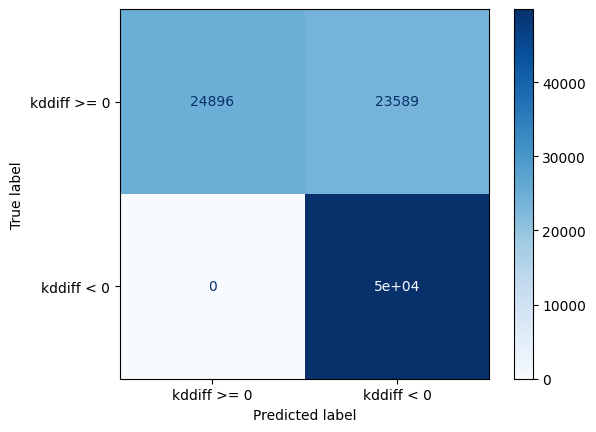

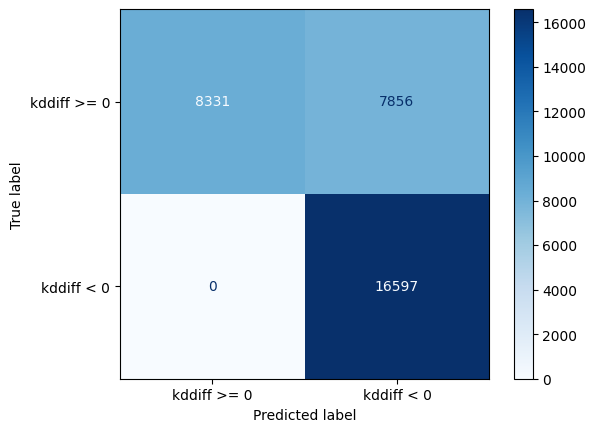

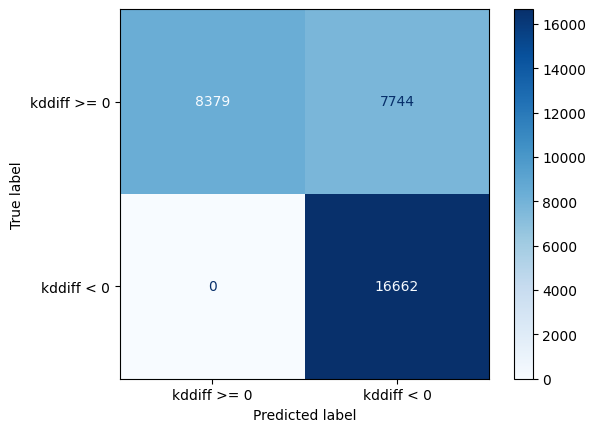

In [49]:
chosen_model = linear_model 
evaluate_model(chosen_model, title='Chosen model', set_names=('train', 'validation', 'test'), show_cm=True)